In [1]:
import sys
sys.path.append('./codes/')
from config import args

args.dataset='syn2'
args.elr = 0.003
args.eepochs = 20
args.coff_size = 0.05
args.budget = -1.0
args.coff_ent = 1.0
args.sample_bias = 0.5

import tensorflow as tf
from utils import *
from models import GCN
from metrics import *
import numpy as np
from Extractor import Extractor
from Explainer import Explainer
from scipy.sparse import coo_matrix,csr_matrix
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


In [2]:
with open('./dataset/' + args.dataset + '.pkl', 'rb') as fin:
    adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, edge_label_matrix  = pkl.load(fin)

adj = csr_matrix(adj)
support = preprocess_adj(adj)

features_tensor = tf.convert_to_tensor(features,dtype=tf.float32)
support_tensor = tf.SparseTensor(*support)
support_tensor = tf.cast(support_tensor,tf.float32)

model = GCN(input_dim=features.shape[1], output_dim=y_train.shape[1])
model.load_weights(args.save_path+ args.dataset)

explainer = Explainer(model=model)
embeds = model.embedding((features_tensor,support_tensor)).numpy()

all_label = np.logical_or(y_train,np.logical_or(y_val,y_test))
single_label = np.argmax(all_label,axis=-1)
hops = len(args.hiddens.split('-'))
extractor = Extractor(adj,features,edge_label_matrix,embeds,all_label,hops)
if args.setting==1:
    if args.dataset=='syn3':
        allnodes = [i for i in range(511,871,6)]
    elif args.dataset=='syn4':
        allnodes = [i for i in range(511,800,1)]
    else:
        allnodes = [i for i in range(400,700,5)] # setting from their original paper
elif args.setting==2:
    allnodes = [i for i in range(single_label.shape[0]) if single_label[i] ==1]
elif args.setting==3:
    if args.dataset == 'syn2':
        allnodes = [i for i in range(single_label.shape[0]) if single_label[i] != 0 and single_label[i] != 4]
    else:
        allnodes = [i for i in range(single_label.shape[0]) if single_label[i] != 0]

optimizer = tf.keras.optimizers.Adam(learning_rate=args.elr)
clip_value_min = -2.0
clip_value_max = 2.0

sub_support_tensors = []
sub_label_tensors = []
sub_features = []
sub_embeds = []
sub_adjs = []
sub_edge_labels = []
sub_labels = []
remap = {}

explainer


In [3]:
for node in allnodes:
    sub_adj,sub_feature, sub_embed, sub_label,sub_edge_label_matrix = extractor.subgraph(node)
    remap[node]=len(sub_adjs)
    sub_support = preprocess_adj(sub_adj)
    sub_support_tensor = tf.cast(tf.SparseTensor(*sub_support),tf.float32)
    sub_label_tensor = tf.convert_to_tensor(sub_label,dtype=tf.float32)

    sub_adjs.append(sub_adj)
    sub_features.append(tf.cast(sub_feature,tf.float32))
    sub_embeds.append(sub_embed)
    sub_labels.append(sub_label)
    sub_edge_labels.append(sub_edge_label_matrix)
    sub_label_tensors.append(sub_label_tensor)
    sub_support_tensors.append(sub_support_tensor)
best_auc = 0.0

In [4]:

def plot(node,label):
    after_adj_dense = explainer.masked_adj.numpy()
    after_adj = coo_matrix(after_adj_dense)

    rcd = np.concatenate([np.expand_dims(after_adj.row,-1),np.expand_dims(after_adj.col,-1),np.expand_dims(after_adj.data,-1)],-1)
    pos_edges = []
    filter_edges = []
    edge_weights = after_adj.data
    sorted_edge_weights = np.sort(edge_weights)
    thres_index = max(int(edge_weights.shape[0]-12),0)
    thres = sorted_edge_weights[thres_index]
    filter_thres_index = min(thres_index,max(int(edge_weights.shape[0]-edge_weights.shape[0]/2),edge_weights.shape[0]-100))
    # filter_thres_index = min(thres_index,max(int(edge_weights.shape[0]-edge_weights.shape[0]/4),edge_weights.shape[0]-100))
    filter_thres = sorted_edge_weights[filter_thres_index]
    filter_nodes =set()

    # print(sorted_edge_weights)
#     print('thres',thres)
    for r,c,d in rcd:
        r = int(r)
        c = int(c)
        if d>=thres:
            pos_edges.append((r,c))
        if d>filter_thres:
            filter_edges.append((r,c))
            filter_nodes.add(r)
            filter_nodes.add(c)

    num_nodes = sub_adj.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(filter_edges)

    for cc in nx.connected_components(G):
        if 0 in cc:
            G = G.subgraph(cc).copy()
            break

    pos_edges = [(u, v) for (u, v) in pos_edges if u in G.nodes() and v in G.nodes()]
    pos = nx.kamada_kawai_layout(G)

    colors = ['orange', 'red', 'green', 'blue', 'maroon', 'brown', 'darkslategray', 'paleturquoise', 'darksalmon',
              'slategray', 'mediumseagreen', 'mediumblue', 'orchid', ]
    if args.dataset=='syn3':
        colors = ['orange', 'blue']


    if args.dataset=='syn4':
        colors = ['orange', 'black','black','black','blue']


    # nodes
    labels = label#.numpy()
    max_label = np.max(labels)+1
#     print(max_label)

    nmb_nodes = after_adj_dense.shape[0]
    label2nodes= []
    for i in range(max_label):
    	label2nodes.append([])
    for i in range(nmb_nodes):
    	label2nodes[labels[i]].append(i)

    for i in range(max_label):
        node_filter = []
        for j in range(len(label2nodes[i])):
            if label2nodes[i][j] in G.nodes():
                node_filter.append(label2nodes[i][j])
        nx.draw_networkx_nodes(G, pos,
                               nodelist=node_filter,
                               node_color=colors[i % len(colors)],
                               node_size=500)

    nx.draw_networkx_nodes(G, pos,
                           nodelist=[0],
                           node_color=colors[labels[0]],
                           node_size=1000)

    nx.draw_networkx_edges(G, pos, width=7, alpha=0.5, edge_color='grey')

    nx.draw_networkx_edges(G, pos,
                           edgelist=pos_edges,
                           width=7, alpha=0.5)


    plt.axis('off')
    plt.show()
#     plt.savefig('./vis/'+args.dataset+'/P'+str(node)+'.png')
    plt.clf()


In [5]:
def train():
    print('extract sub graphs done')
    t0 = args.coff_t0
    t1 = args.coff_te
    epochs = args.eepochs
    for epoch in range(epochs):
        train_accs = []
        loss = 0
        pred_loss = 0
        lap_loss = 0
        tmp = 1.0
        with tf.GradientTape() as tape:
            for i in range(len(allnodes)):
                output = model.call((sub_features[i],sub_support_tensors[i]),training=False)
                train_acc = accuracy(output, sub_label_tensors[i])
                train_accs.append(float(train_acc))
                pred_label = tf.argmax(output, 1)

                x = sub_features[i]
                adj = sub_adjs[i]
                nodeid = 0
                embed = sub_embeds[i]
                pred = explainer((x,adj,nodeid,embed,tmp),training=True)
                l,pl,ll = explainer.loss(pred, pred_label, sub_label_tensor, 0)
                loss += l
                pred_loss += pl
                lap_loss += ll
            train_variables = []
            for para in explainer.trainable_variables:
                if para.name.startswith('explainer'):
                    train_variables.append(para)
        grads = tape.gradient(loss, train_variables)
        cliped_grads = [tf.clip_by_value(t, clip_value_min, clip_value_max) for t in grads]
        optimizer.apply_gradients(zip(cliped_grads, train_variables))

        print('pred_loss_mean',np.mean(pred_loss.numpy()))

        explainer.save_weights(args.save_path + 'expaliner_'+args.dataset)


reals = []
preds = []
def acc(sub_adj,sub_edge_label):
    real = []
    pred = []
    sub_edge_label = sub_edge_label.todense()
    mask = explainer.masked_adj.numpy()
    for r,c in list(zip(sub_adj.row,sub_adj.col)):
        d = sub_edge_label[r,c] + sub_edge_label[c,r]
        if d==0:
            real.append(0)
        else:
            real.append(1)
        pred.append(mask[r][c]+mask[c][r])
    reals.extend(real)
    preds.extend(pred)

    if len(np.unique(real))==1 or len(np.unique(pred))==1:
        return -1
    return roc_auc_score(real,pred)

In [6]:
def explain_test(node,needplot=True):
    newid = remap[node]
    sub_adj, sub_feature, sub_embed, sub_label, sub_edge_label =  sub_adjs[newid],sub_features[newid],sub_embeds[newid],sub_labels[newid],sub_edge_labels[newid]

    nodeid = 0
    explainer((sub_feature,sub_adj,nodeid,sub_embed,1.0),training=False)
    label = np.argmax(sub_label,-1)
    if needplot:
        plot(node,label)
    acc(sub_adj,sub_edge_label)


In [7]:
train()


extract sub graphs done
pred_loss_mean 232.4529
pred_loss_mean 250.8273
pred_loss_mean 286.36267
pred_loss_mean 331.67468
pred_loss_mean 374.98135
pred_loss_mean 379.18094
pred_loss_mean 345.51715
pred_loss_mean 301.1028
pred_loss_mean 258.0067
pred_loss_mean 322.62323
pred_loss_mean 339.846
pred_loss_mean 251.70137
pred_loss_mean 133.5112
pred_loss_mean 120.812675
pred_loss_mean 149.29082
pred_loss_mean 163.96597
pred_loss_mean 169.4898
pred_loss_mean 169.7347
pred_loss_mean 163.67268
pred_loss_mean 142.09462


In [8]:
explainer.load_weights(args.save_path + 'expaliner_'+args.dataset)

In [9]:

reals= []
preds = []
for node in allnodes:
    explain_test(node,needplot=False)
    auc = roc_auc_score(reals, preds)
    print('node ',node, 'auc',auc)

print('mean acc',auc)

node  400 auc 1.0
node  405 auc 0.9919786096256685
node  410 auc 0.9876941821504722
node  415 auc 0.9883202752559798
node  420 auc 0.9785652762396948
node  425 auc 0.9829293219635272
node  430 auc 0.9606771345486644
node  435 auc 0.9610502019619156
node  440 auc 0.9614795872042283
node  445 auc 0.9619992984148562
node  450 auc 0.9637875844082657
node  455 auc 0.965424182638106
node  460 auc 0.9640292979400514
node  465 auc 0.9655365714477526
node  470 auc 0.968429017409357
node  475 auc 0.9695623130318609
node  480 auc 0.9671428682439895
node  485 auc 0.967665459949877
node  490 auc 0.9684769868298401
node  495 auc 0.9671248231676663
node  500 auc 0.9657392250310817
node  505 auc 0.9658961946306344
node  510 auc 0.9659999017602772
node  515 auc 0.9648449866296652
node  520 auc 0.965488801881624
node  525 auc 0.9660635766994559
node  530 auc 0.9658874329958309
node  535 auc 0.9659378790726282
node  540 auc 0.9672137356903103
node  545 auc 0.9690100546587609
node  550 auc 0.9698543319308

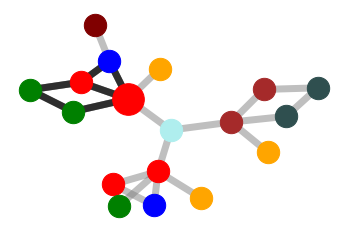

<Figure size 432x288 with 0 Axes>

In [10]:
explain_test(allnodes[1],needplot=True)